# Particle Identification using GNN on HGCAL dataset- Adding PILEUP

We have already done the following:
1. Added a Gaussian Noise.
2. We had done the normalization per hit per layer. This had completely removed the longitudinal profile information. We only had the lateral profile- per layer relative energy at each hit cell, with respect to the hit cell with maximum energy deposit in that particular layer
3. We added the longitudinal profile information manually using the *layer profile*, which is the normalized tensor, representing the per event relative total energy in each layer, with respect to the layer with maximum total hit energy.
4. We had developed a more **intense** architecture.
5. We had further added a **Graph Attention Network**

Now, we shall do a further important topic,i.e, adding **pileup events**

## Importing the required packages

In [ ]:
#General packages
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

#Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

#Packages for GNN
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
#from torch_geometric.nn import GCNConv, global_add_pool
from sklearn.neighbors import NearestNeighbors

## ROOT ---> Numpy arrays

In [ ]:
#file=uproot.open("ntuple_pi+_100GeV_100keve.root:AllLayers")
#branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
#events=file.arrays(branches,library="ak")


In [ ]:
#events  ### Awkawrd array in Dictionary like format
#type(events)
#events.hit_x # Returns the awkard arrays for the hit_x for all events

In [ ]:
#events[0].hit_x # Returns the hit_x data for the first event, as numpy arrays

## Preparing the Dataset

In [ ]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    "K-":"ntuple_kaon-_100GeV_20keve_p1.root:AllLayers",
    "K+":"ntuple_kaon+_100GeV_20keve_p1.root:AllLayers",
    "K_0":"ntuple_kaon0L_100GeV_10keve_test.root:AllLayers",
    "mu+":"ntuple_mu+_100GeV_100keve.root:AllLayers",
    "n":"ntuple_neutron_100GeV_10keve_test.root:AllLayers",
    "p":"ntuple_proton_100GeV_20keve_p1.root:AllLayers"
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2,
    "K-":3,
    "K+":4,
    "K_0":5,
    "mu+":6,
    "n":7,
    "p":8
}


In [ ]:
#Defining the root files and their path names
particle_files={
    "pi+":"ntuple_pi+_100GeV_100keve.root:AllLayers",
    "e+":"ntuple_e+_100_GeV_100Keve.root:AllLayers",
    "Y":"ntuple_gamma_100GeV_25keve_p1.root:AllLayers",
    
}
particle_ids={
    "pi+":0,
    "e+":1,
    "Y":2
}


In [ ]:
branches=["hit_x","hit_y","hit_z","hit_l","hit_E"]
all_events=[]
all_labels=[]

for pname,file_path in particle_files.items():
    file=uproot.open(file_path)
    events=file.arrays(branches,library="ak")[:1000] #Only 1000 events for now
    #Assigning particle ids
    pid=particle_ids[pname]
    #Store everything as a tuple
    all_events.extend([(events[i],pid) for i in range(len(events))])

In [ ]:
#Shuffling
from sklearn.utils import shuffle
all_events=shuffle(all_events,random_state=28)

In [ ]:
all_events[0][0]

In [ ]:
all_events[0][1]

In [ ]:
#pid = {v: k for k, v in particle_ids.items()}
#class_names=[pid[i] for i in range(len(pid))]

In [ ]:
#len(class_names)

In [ ]:
#for i,name in enumerate(class_names):
#    print(name)

In [ ]:
all_events[4][1]

In [ ]:
np.sum(all_events[0][0].hit_E)

In [ ]:
np.sum(all_events[0][0].hit_E)

## Adding Noise

In [ ]:
def add_HGCAL_noise(event,noise_mean,N=0.05,threshold_sigma=None,random_state=None):
    signal=np.array(event.hit_E)
    #Computing the sigma
    #sigma=np.sqrt((a**2)*signal + b**2)
    sigma=N
    #Compute the Gaussian noise, with this sigma
    noise=np.random.normal(loc=0.0,scale=sigma,size=np.size(signal))
    E_noisy=signal+noise
    #Clipping zero and negative energies
    E_noisy[E_noisy<=0]=0.0
    #Optional zero suppression- based on threshold
    if threshold_sigma is not None:
        threshold=threshold_sigma*b
        E_noisy[E_noisy<threshold]=0.0
    #Newly record the data
    event_noisy=ak.Record(
    {
        "hit_x":event.hit_x,
        "hit_y":event.hit_y,
        "hit_z":event.hit_z,
        "hit_l":event.hit_l,
        "hit_E":E_noisy
    })
    
    return event_noisy

In [ ]:
np.random.seed(42) #For explaining reproductivity
all_events_noisy=[]
noise_mean=0.0
#noise_std=0.03

for event,pid in all_events:
    event_noisy=add_HGCAL_noise(event,noise_mean=noise_mean)
    all_events_noisy.append((event_noisy,pid))

In [ ]:
all_events_noisy[0][0]

## Adding PileUp

We will follow three steps now to create a toy model.
1. Generate random numbers following exponential distribution.
2. Fit the random numbers in a histogram. This will give me the energy profile for the pileups
3. Using this historam, further generate random numbers

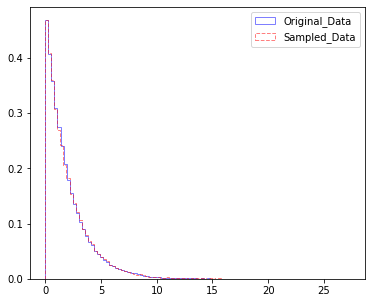

In [17]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#from scipy.stats import gaussian_kde
#------ Step-1: Generating Random exponential numbers ------#
lambda_val=2.0 
N_samples=100000
exp_vals=np.random.exponential(scale=lambda_val,size=N_samples)
#------ Step-2: Build the Histogram ------#
num_bins=100
counts,bin_edges=np.histogram(exp_vals,bins=num_bins,density=False)
#------ Step-3: Sampling from the Histogram -----#
#### Build the CDF
probablities=counts/np.sum(counts)
cdf=np.cumsum(probablities)
def sample_from_histogram(n_samples):
    sampled_values=[]
    for _ in range(n_samples):
        u=np.random.rand()
        bin_index=np.searchsorted(cdf,u)
        #Identify the bin edges
        E_low=bin_edges[bin_index]
        E_high=bin_edges[bin_index+1]
        #Sampling within the bin
        r=np.random.rand()
        E_sample=E_low+(E_high-E_low)*r
        sampled_values.append(E_sample)
    return sampled_values
sam_vals=sample_from_histogram(100000)
#sam_vals=np.array(sam_vals)
#x=np.linspace(sam_vals.min(),sam_vals.max(),1000)
##### Plotting##### 
plt.figure(figsize=(6,5))
plt.hist(exp_vals,bins=100,histtype='step',color='blue',density=True,alpha=0.5,label='Original_Data')
plt.hist(sam_vals,bins=100,histtype='step',color='red',linestyle='--',density=True,alpha=0.5,label='Sampled_Data')
#sns.kdeplot(data=sam_vals, fill=True, color='purple', label='Estimated PDF (KDE)')
#kde=gaussian_kde(sam_vals)
#pdf=kde(x)
#plt.plot(x, pdf, color='purple', lw=2, label='Estimated PDF (KDE)')
plt.legend(loc='best')

In [19]:
# Now, we need to generate the pileup energy per event.
N_pileups_per_event=50

def generate_event_pileup(n_pileups,histogram_sample):
    # Randomly select 'n_pileups' no. of energies from the histogram
    pileup_energy=np.random.choice(histogram_sample,size=n_pileups)
    #Total pileup energy per event
    total_pileup_energy=np.sum(pileup_energy)
    return total_pileup_energy
total_E=generate_event_pileup(N_pileups_per_event,sam_vals)

In [20]:
total_E

95.15096330636479

## Longitudinal profile- Layer Energy Profile

In [ ]:
def layer_profile(event,global_max_layers=50):
    layers=ak.to_numpy(event.hit_l)
    layers=torch.tensor(layers)
    energies=ak.to_numpy(event.hit_E)
    energies=torch.tensor(energies)
    layer_sums=torch.bincount(input=layers-1,weights=energies,minlength=global_max_layers)
    #Maximum energy
    max_energy=layer_sums.max()
    if max_energy>0:
        layer_sums_norm=layer_sums/max_energy
    #return torch.tensor(layer_sums_norm,dtype=torch.float64)
    layer_sums_norm=torch.unsqueeze(layer_sums_norm,0)
    return layer_sums_norm

In [ ]:
#Test
layer_profile(all_events_noisy[4][0]).shape

In [ ]:
#layer_profile(all_events_noisy[5][0])

In [ ]:
#A=torch.tensor([1,2,3])
#B=torch.unsqueeze(A,0)
#B.shape
#A.unsqueeze(0)
#print(A.shape)

## Lateral Profile- Average energy per hits per layer

In [ ]:
def normalize_hits_by_layer(event):
    layer=ak.to_numpy(event.hit_l)
    energy=ak.to_numpy(event.hit_E)
    #Prepare an array to store normalized energies
    energy_norm=np.zeros_like(energy)
    #Finding unique layers
    unique_layer=np.unique(layer)
    for l in unique_layer:
        #Extract the inndices of the hits in this layer
        mask=layer==l
        if np.any(mask):
            max_energy=energy[mask].max()
            if max_energy>0:
                energy_norm[mask]=energy[mask]/max_energy
            elif max_energy==0:
                energy_norm[mask]=0.0
    #Rebuild the record
    event_norm=ak.Record({
        "hit_x":event.hit_x,
        "hit_y":event.hit_y,
        "hit_z":event.hit_z,
        "hit_l":event.hit_l,
        "hit_E":energy_norm
    })
    return event_norm

In [ ]:
all_events_normalized=[]
for event,pid in all_events_noisy:
    event_norm=normalize_hits_by_layer(event)
    all_events_normalized.append((event_norm,pid))

## Creating the event graphs

In [ ]:
def create_graph(event,k=8):
    x=ak.to_numpy(event.hit_x)
    y=ak.to_numpy(event.hit_y)
    z=ak.to_numpy(event.hit_z)
    l=ak.to_numpy(event.hit_l)
    E=ak.to_numpy(event.hit_E)
    #Removing zero energy hits
    mask_E=E>0
    x,y,z,l,E=x[mask_E],y[mask_E],z[mask_E],l[mask_E],E[mask_E]
    coords=np.column_stack((x,y,z))
    N=len(coords)
    if N<k+1:
        return None
    
    #Node features
    node_features=torch.from_numpy(np.column_stack((x,y,z,l,E))).float()

    #Global KNN
    knn=NearestNeighbors(n_neighbors=k+1,algorithm="kd_tree").fit(coords)
    knn_dist,knn_idx=knn.kneighbors(coords)
    knn_idx=knn_idx[:,1:] #Removes the self hit
    #print(knn_dist[9,:],knn_idx[9,:])

    #Edge construction
    src=np.repeat(np.arange(N),k)
    dst=knn_idx.reshape(-1)
    mask=dst>=0
    src,dst=src[mask],dst[mask]
    edge_index=torch.tensor(np.vstack([src,dst]),dtype=torch.long)

    #Edge attributes
    edge_attr = torch.tensor((E[src] * E[dst]).reshape(-1, 1),dtype=torch.float)

    #Final creation
    graph= Data(x=node_features,edge_index=edge_index,edge_attr=edge_attr)
    return graph

In [ ]:
#graph=[create_graph(event,k=8) for event in events]    

In [ ]:
#creating graphs for all events
graph=[]
for event,pid in all_events_noisy:
    g=create_graph(event,k=8)
    profile=layer_profile(event,global_max_layers=50)
    if g is not None:
        g.y=torch.tensor([pid],dtype=torch.long)
        g.layer_profile=profile
        graph.append(g)

In [ ]:
graph[0]

In [ ]:
#Debugging-1
#for g in graph[:20]:
#    print(g.y.item())

In [ ]:
#Debugging-2
#g = graph[3]
#print(g.y)
#print(g.y.shape)


In [ ]:
#Test-1
graph[:20]

In [ ]:
#Test-2
graph[2].layer_profile

## Splitting into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

#First split: Train vs Temp(Val+Test)
train_data, temp_data= train_test_split(graph, test_size=0.3, random_state=42)

#Second split: Test vs Val
val_data, test_data= train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

In [ ]:
#graph[:64]

## Using DataLoader

In [ ]:
from torch_geometric.loader import DataLoader
batch_size=64

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Making the GCN

### Developing the Message Passing Block

In [ ]:
#Making the message passing network
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
class GCNConv(MessagePassing):
    def __init__(self,in_channels,out_channels):
        #Here, in_channels: Input node features
        super().__init__(aggr='add')
        self.lin=Linear(in_channels,out_channels,bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
        
    def forward(self,x,edge_index):
        # x has the shape [No. of hits, in_channels]
        #edge_index has shape [2, No. of edges]
        #Step-1: Add self loops
        edge_index,_=add_self_loops(edge_index,num_nodes=x.size(0))
        #Step-2: Linearly transform node feature matrix
        x=self.lin(x)
        #Step-3: Compute Normalization
        row,col=edge_index
        deg=degree(col,x.size(0))
        deg_inv_sqr=deg.pow(-0.5)
        deg_inv_sqr[deg_inv_sqr==float('inf')]=0
        norm=deg_inv_sqr[row]*deg_inv_sqr[col]
        #Step-4-5: Propagating the message- Normalize the node features and then add
        out=self.propagate(edge_index,x=x,norm=norm)
        #Step 6: Apply the end bias vector
        out=out+self.bias
        
        return out
    
    def message(self, x_j, norm):
        return norm.view(-1,1)*x_j

### Stacking the GNN layers for 'Convolution'

#### Advanced Model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool,BatchNorm

class GCN_Event_Classifier(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim):
        super().__init__()
        #The GCN Layers
        ## First-layer
        self.conv1=GCNConv(input_dim,hidden_dim)
        self.bn1=BatchNorm(hidden_dim)
        ## 6 repeated blocks
        self.convs=nn.ModuleList()
        self.bns=nn.ModuleList()
        for i in range(6):
            self.convs.append(GCNConv(hidden_dim,hidden_dim))
            self.bns.append(BatchNorm(hidden_dim))
        ##Final layer
        self.final_conv=GCNConv(hidden_dim,hidden_dim)
        #Regularization
        self.dropout=nn.Dropout(p=0.1)
        
        #Output- MLP- mainly doing the classification task.
        self.output=nn.Sequential(
            nn.Linear(hidden_dim+50,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
        
    def forward(self,data):
        #x,edge_index=data.x, data.edge_index
        x,edge_index,batch=data.x,data.edge_index,data.batch
        #print(data.x.shape)
        
        #-----------Graph Convolution--------------
        #####First GCN Block#######
        x=self.conv1(x,edge_index)
        x=self.bn1(x)
        x=F.relu(x)
        x=self.dropout(x)
        #### Repeated convolutions ####
        for conv,bn in zip(self.convs,self.bns):
            x=conv(x,edge_index)
            x=bn(x)
            x=F.relu(x)
            x=self.dropout(x)
        #### Final convolution ####
        x=self.final_conv(x,edge_index)
        #Saving the node embeddings
        node_embedding=x
        #print(node_embedding.shape)
        
        #Graph-level event embedding
        event_embedding=global_add_pool(x,batch) # shape: [batch_size,hidden_dim]
        #print(event_embedding.shape)
        
        #Get layer profile
        layer_profile=data.layer_profile
        #print(layer_profile.shape)
        #if layer_profile.dim()==1:
        #    layer_profile=layer_profile.unsqueeze(0)
        layer_profile=layer_profile.float()
        #layer_profile.unsqueeze(0)
        #if layer_profile.size(0)!=event_embedding.size(0):
        #    layer_profile=layer_profile.expand(event_embedding.size(0),-1)
            
        
        #layer_profile=data.layer_profile.float()
        #Combined- Concatenate the features
        combined=torch.cat([event_embedding,layer_profile],dim=1)
        #print(combined.shape)
        #Node-level-predictions
        out=self.output(combined)
        
        return out,node_embedding

## Making the GAT

### Making the Message Passing Block

### Stacking the GAT layers

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_add_pool,BatchNorm

class GAT_Event_Classifier(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim,heads):
        super().__init__()
        self.heads=heads
        #The GCN Layers
        ## First-layer
        #self.conv1=GCNConv(input_dim,hidden_dim)
        self.conv1=GATConv(input_dim,hidden_dim, heads=heads,concat=False,dropout=0.1) 
        #concat=False means 'mean of two heads
        self.bn1=BatchNorm(hidden_dim)
        ## 6 repeated blocks
        self.convs=nn.ModuleList()
        self.bns=nn.ModuleList()
        for i in range(6):
            self.convs.append(GATConv(hidden_dim,hidden_dim,heads=heads,concat=False,dropout=0.1))
            self.bns.append(BatchNorm(hidden_dim))
        ##Final layer
        self.final_conv=GATConv(hidden_dim,hidden_dim,heads=heads,concat=False,dropout=0.1)
        #Regularization
        self.dropout=nn.Dropout(p=0.1)
        
        #Output- MLP- mainly doing the classification task.
        self.output=nn.Sequential(
            nn.Linear(hidden_dim+50,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            #nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
        
    def forward(self,data):
        #x,edge_index=data.x, data.edge_index
        x,edge_index,batch=data.x,data.edge_index,data.batch
        #print(data.x.shape)
        
        #-----------Graph Convolution--------------
        #####First GCN Block#######
        x=self.conv1(x,edge_index)
        x=self.bn1(x)
        x=F.relu(x)
        x=self.dropout(x)
        #### Repeated convolutions ####
        for conv,bn in zip(self.convs,self.bns):
            x=conv(x,edge_index)
            x=bn(x)
            x=F.relu(x)
            x=self.dropout(x)
        #### Final convolution ####
        x=self.final_conv(x,edge_index)
        #Saving the node embeddings
        node_embedding=x
        #print(node_embedding.shape)
        
        #Graph-level event embedding
        event_embedding=global_add_pool(x,batch) # shape: [batch_size,hidden_dim]
        #print(event_embedding.shape)
        
        #Get layer profile
        layer_profile=data.layer_profile
        #print(layer_profile.shape)
        #if layer_profile.dim()==1:
        #    layer_profile=layer_profile.unsqueeze(0)
        layer_profile=layer_profile.float()
        #layer_profile.unsqueeze(0)
        #if layer_profile.size(0)!=event_embedding.size(0):
        #    layer_profile=layer_profile.expand(event_embedding.size(0),-1)
            
        
        #layer_profile=data.layer_profile.float()
        #Combined- Concatenate the features
        combined=torch.cat([event_embedding,layer_profile],dim=1)
        #print(combined.shape)
        #Node-level-predictions
        out=self.output(combined)
        
        return out,node_embedding

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
#model=GCN_Event_Classifier(input_dim=5,hidden_dim=64,output_dim=9).to(device)
layer_dim=graph[0].layer_profile.shape[0]
model=GAT_Event_Classifier(input_dim=5,hidden_dim=25,heads=2,output_dim=3).to(device)

In [ ]:
model

### Developing the training, validation and testing loops

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=torch.nn.CrossEntropyLoss()

In [ ]:
#Training loop
def train():
    model.train()
    total_loss=0.0
    for batch in train_loader:
        batch=batch.to(device)
        optimizer.zero_grad()
        #Computing batchwise layer profiles
        #profiles=layer_profile_batchwise(batch,global_max_layers=50)
        out,_=model(batch)
        loss=criterion(out,batch.y)
        #Backpropagation
        loss.backward() 
        optimizer.step()
        total_loss+=loss.item()
        
    return total_loss/len(train_loader)


In [ ]:
#Validation loop
def validate():
    model.eval()
    total_loss=0.0
    with torch.no_grad():
        for batch in val_loader:
            batch=batch.to(device)
            out,_=model(batch)
            loss=criterion(out,batch.y)
            total_loss+=loss.item()
    return total_loss/len(val_loader)

In [ ]:
#Running the model
epochs=100
#epochs=500
train_losses=[]
val_losses=[]
for epochs in range(1,epochs+1):
    train_loss=train()
    val_loss=validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epochs}, Train Loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

In [ ]:
#Visualizing the model performance
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(range(1,len(train_losses)+1),train_losses,label="Training loss",color="Blue")
plt.plot(range(1,len(val_losses)+1),val_losses,label="Validation loss",color="Red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

### Inferences(Performance) of the model

In [ ]:
# Testing the model
model.eval()
predictions=[]
true_labels=[]
probablities=[]

with torch.no_grad():
    for batch in test_loader:
        batch=batch.to(device)
        out,_=model(batch)
        preds=torch.argmax(out,dim=1)  #Predictions
        probs=torch.softmax(out,dim=1) #Probablities
        
        predictions.append(preds.cpu())
        true_labels.append(batch.y.cpu())
        probablities.append(probs.cpu())
    
predictions=torch.cat(predictions)
true_labels=torch.cat(true_labels)
probablities=torch.cat(probablities)

#### Confusion matrix

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(true_labels,predictions,normalize='true')


In [ ]:
pid = {v: k for k, v in particle_ids.items()}
class_names=[pid[i] for i in range(len(pid))]

In [ ]:
plt.figure(figsize=(8,6))

sns.heatmap(cm,
            annot=True,
            fmt='.2%',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Particle")
plt.ylabel("True Particle")
plt.title("Confusion Matrix - Particle Identification")

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


#### ROC curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc

#Here, we need to convert the labels to one-hot levels for ROC only
num_classes=3
y_true_bin=label_binarize(true_labels.numpy(),classes=range(num_classes))
y_score=probablities.numpy()

plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr,_=roc_curve(y_true_bin[:,i],y_score[:,i])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'{class_names[i]}(AUC={roc_auc:.2f})')
plt.grid()
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves-GCN")
plt.legend()
plt.show()

#### Signal and Background distribution per particle

In [ ]:
pid = {v: k for k, v in particle_ids.items()}
class_names=[pid[i] for i in range(len(pid))]
for i, name in enumerate(class_names):
    #Signal
    signal_mask = (true_labels == i)
    signal_probs = probablities[signal_mask, i].cpu().numpy()
    #Background
    background_mask=(true_labels!=i)
    background_probs=probablities[background_mask,i].cpu().numpy()
    #Plotting
    plt.figure(figsize=(6,5))
    plt.hist(signal_probs,bins=50,histtype='step',color='blue', density=True,linewidth=2,alpha=0.7,label='Signal')
    plt.hist(background_probs,bins=50,histtype='step',color='red', density=True,linewidth=2,alpha=0.7,linestyle='--',label='Background')
    plt.xlabel(f"P({name})")
    plt.ylabel("Normalised Entries")
    plt.title(f"Signal and Background Distribution for {name}")
    plt.yscale('log')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

In [ ]:
#Subplot view
pid = {v: k for k, v in particle_ids.items()}
class_names=[pid[i] for i in range(len(pid))]
num_classes=len(class_names)
#Plotting
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.linewidth": 1.5,
})
fig,axes=plt.subplots(1,num_classes,figsize=(5*num_classes,2*num_classes),sharey=True)

for i,(ax,name) in enumerate(zip(axes,class_names)):
    #Signal
    signal_mask=(true_labels==i)
    signal_probs=probablities[signal_mask,i].cpu().numpy()
    #Background
    background_mask=(true_labels!=i)
    background_probs=probablities[background_mask,i].cpu().numpy()
    #Plotting
    #bins=np.linspace(0,1,50)
    #plt.figure(figsize=(6,5))
    ax.hist(signal_probs,bins=50,histtype='step',color='blue', density=True,linewidth=2,alpha=0.7,label='Signal')
    ax.hist(background_probs,bins=50,histtype='step',color='red', density=True,linewidth=2,alpha=0.7,linestyle='--',label='Background')
    ax.set_xlabel(f"P({name})")
    ax.set_ylabel("Density")
    ax.set_yscale('log')
    #ax.set_xlim(0,1)
    #plt.title(f"Probablity distribution of True {name}")
    #plt.show()